In [64]:
# import stuff
import os, sys, time
import tifffile as tif
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

In [39]:
# this will mean I need to make sure same labels are same across all files
# but I might need to make each file separate

In [201]:
# trying something diff
lab_fischer = pd.read_csv('/Users/emilydennis/Desktop/sagittal_fischer_labels_withPRA.csv')
lab_sigma = pd.read_csv('/Users/emilydennis/Desktop/SIGMA_labels_withPRA.csv')
lab_schwarz = pd.read_csv('/Users/emilydennis/Desktop/sagittal_schwarz_labels_withPRA.csv')

In [70]:
fischer = tif.imread('/Users/emilydennis/Desktop/sagittal_fischer_in_mPRA.tif')
sigma = tif.imread('/Users/emilydennis/Desktop/new/mPRA_SIGMA_annotation-volume.tif')
schwarz = tif.imread('/Users/emilydennis/Desktop/sagittal_schwarz_in_mPRA.tif')

In [72]:
mpramask = tif.imread('/Users/emilydennis/Desktop/new/today/mPRA-mask.tif')

In [202]:
def get_a_b(A,Alab,B,Blab,mask):
    [xmax,ymax,zmax] = np.shape(mask)
    x=400
    y=400
    badlist=[]
    distlist = []
    #for x in arange(0,xmax):
    #for y in arange(0,ymax):
    for z in np.arange(0,zmax):
        if mask[x,y,z] > 0:
            #for each non zero voxel, get values
            [Aname,Aparent] = get_parent(A,Alab,x,y,z)
            [Bname,Bparent] = get_parent(B,Blab,x,y,z)
            if Aname!=Bname:
                if Aname!=Bparent:
                    if Aparent!=Bparent:
                        badlist.append([x,y,z,Aname,Bname])
    return badlist

In [203]:
def get_parent(volume,labeledvolume,x,y,z):
    # assumes you have a column called 'parent'
    val = volume[x,y,z]
    print(z,val)
    if val > 0:
        valname = labeledvolume.loc[labeledvolume.ID==val,'name'].values[0]
        parentname = labeledvolume.loc[labeledvolume.ID==val,'parent'].values[0]
    else:
        valname=0
        parentname=0
    return valname, parentname


In [204]:
get_a_b(fischer,lab_fischer,schwarz,lab_schwarz,mpramask)

32 0
32 67
33 0
33 67
34 0
34 67
35 0
35 67
36 0
36 67
37 95
37 67
38 95
38 67
39 95
39 67
40 95
40 67
41 95
41 67
42 95
42 67
43 95
43 67
44 95
44 67
45 95
45 67
46 95
46 67
47 95
47 67
48 95
48 67
49 95
49 67
50 95
50 67
51 95
51 67
52 95
52 67
53 95
53 67
54 95
54 67
55 95
55 67
56 95
56 67
57 95
57 67
58 95
58 67
59 95
59 67
60 95
60 67
61 95
61 67
62 95
62 67
63 95
63 67
64 95
64 67
65 95
65 67
66 95
66 67
67 95
67 67
68 95
68 67
69 95
69 67
70 95
70 67
71 95
71 67
72 95
72 67
73 95
73 67
74 95
74 67
75 95
75 67
76 95
76 67
77 95
77 67
78 95
78 67
79 95
79 67
80 95
80 67
81 95
81 67
82 95
82 67
83 95
83 67
84 95
84 67
85 95
85 67
86 95
86 67
87 95
87 67
88 95
88 67
89 95
89 67
90 95
90 67
91 95
91 67
92 95
92 67
93 95
93 67
94 95
94 67
95 95
95 67
96 95
96 67
97 95
97 67
98 95
98 67
99 14
99 255
100 14
100 255
101 14
101 255
102 14
102 255
103 14
103 255
104 14
104 255
105 14
105 255
106 14
106 255
107 14
107 255
108 14
108 255
109 14
109 255
110 14
110 255
111 2
111 255
112 2
112

[[400, 400, 32, 0, 'medulla_Left'],
 [400, 400, 33, 0, 'medulla_Left'],
 [400, 400, 34, 0, 'medulla_Left'],
 [400, 400, 35, 0, 'medulla_Left'],
 [400, 400, 36, 0, 'medulla_Left'],
 [400, 400, 37, 'Cortex', 'medulla_Left'],
 [400, 400, 38, 'Cortex', 'medulla_Left'],
 [400, 400, 39, 'Cortex', 'medulla_Left'],
 [400, 400, 40, 'Cortex', 'medulla_Left'],
 [400, 400, 41, 'Cortex', 'medulla_Left'],
 [400, 400, 42, 'Cortex', 'medulla_Left'],
 [400, 400, 43, 'Cortex', 'medulla_Left'],
 [400, 400, 44, 'Cortex', 'medulla_Left'],
 [400, 400, 45, 'Cortex', 'medulla_Left'],
 [400, 400, 46, 'Cortex', 'medulla_Left'],
 [400, 400, 47, 'Cortex', 'medulla_Left'],
 [400, 400, 48, 'Cortex', 'medulla_Left'],
 [400, 400, 49, 'Cortex', 'medulla_Left'],
 [400, 400, 50, 'Cortex', 'medulla_Left'],
 [400, 400, 51, 'Cortex', 'medulla_Left'],
 [400, 400, 52, 'Cortex', 'medulla_Left'],
 [400, 400, 53, 'Cortex', 'medulla_Left'],
 [400, 400, 54, 'Cortex', 'medulla_Left'],
 [400, 400, 55, 'Cortex', 'medulla_Left'],
 [4

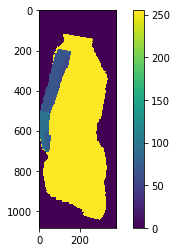

In [200]:
plt.imshow(schwarz[400,:,:])
plt.colorbar()

In [192]:
lab_fischer[lab_fischer.ID>200]

,ID,_abbreviation,name,"Matter_Type_{Gray,White,ventricle}",parent,PRAID
2,243.0,bas,Basal_Forebrain,G,pallidum,7100.0
14,225.0,Cpu,Cerebral_Peduncle,W,cerebellum,200.0
16,202.0,coch,Cochlear_Nucleus,G,medulla,5120.0
24,231.0,DG,Dentate_Gyrus,G,hippocampal_formation,3013.0
36,216.0,CA1,Hippocampal_CA_Subfields,G,hippocampal_formation,3000.0
37,210.0,hyp,Hypothalamus,G,Midbrain,4000.0
43,229.0,LSC,Lateral_Septum,G,pallidum,7300.0
45,246.0,MB,Mammillary_bodies,G,hypothalamus,4000.0
47,227.0,MS,Medial_Septum,G,pallidum,7300.0
49,208.0,mid,Midbrain,G,Midbrain,5200.0


In [125]:
print(schwarz[x,y,z])
print(fischer[x,y,z])


67
0


AttributeError: 'Series' object has no attribute 'value'

In [106]:
#def get_family_tree(entry,volume,labeledvolume):
 #get parent if parent of parent isn't root   

In [17]:
# for a given csv file, read in as a pandas df
def csv_to_pd(filename):
    fn=[]
    with open(filename) as csvfile:
        reader = csv.reader(csvfile,delimiter=',')
        for row in reader:
            fn.append(row)
    fnd = pd.DataFrame(fn)
    return fnd

In [38]:
#for a column in a df, replace spaces with _ and make all lowercase
def make_column_safe(df,num):
    for idx in df.index:
        strfx = df[num][idx]
        strfx = strfx.replace(' ','_').lower()
        df[num][idx] = strfx
    return df

In [61]:
whs = csv_to_pd("/Users/emilydennis/Desktop/today/WHS_labels.csv")
whs = make_column_safe(whs,1)

sigma = csv_to_pd("/Users/emilydennis/Desktop/today/SIGMA_labels.csv")
sigma = make_column_safe(sigma,2)